In [8]:
import numpy as np
import os
from stochastic.continuous import FractionalBrownianMotion
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, accuracy_score, classification_report, confusion_matrix)
import seaborn as sns

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
class DataLoader:
    def __init__(self, alpha_range, ratio_aN, num_traj=10000, t_max=1000):
        self.data_fbm = None
        self.targets_fbm = None
        self.alphas_fbm = None
        self.data_ctrw = None
        self.targets_ctrw = None
        self.processes_ctrw = None
        self.data_full = None
        self.targets_full = None
        self.load(alpha_range, ratio_aN, num_traj, t_max)
        self.compute_full()

    def get_data_full(self):
        if self.data_full is not None:
            return self.data_full
        else:
            print('self.data_full is None!')
    
    def get_targets_full(self):
        if self.targets_full is not None:
            return self.targets_full
        else:
            print('self.targets_full is None!')
            
    def get_data_fbm(self):
        if self.data_fbm is not None:
            return self.data_fbm
        else:
            print('self.data_fbm is None!')
            
    def get_alphas_fbm(self):
        if self.alphas_fbm is not None:
            return self.alphas_fbm
        else:
            print('self.alphas_fbm is None!')
            
    def get_targets_fbm(self):
        if self.targets_fbm is not None:
            return self.targets_fbm
        else:
            print('self.targets_fbm is None!')
    
    def load(self, alpha_range, ratio_aN, num_traj, t_max):
        self.load_fbm(alpha_range, ratio_aN, num_traj, t_max)
        self.load_ctrw(alpha_range, ratio_aN, num_traj, t_max)
        
    def compute_full(self):
        self.data_full = np.vstack((self.data_fbm, self.data_ctrw))
        self.targets_full = np.vstack((self.targets_fbm.reshape(-1, 1), 
                                       self.targets_ctrw.reshape(-1, 1))).reshape(-1, 1)
        
    def load_fbm(self, alpha_range, ratio_aN, num_traj, t_max):
        if self.data_fbm is None:
            self.data_fbm, self.alphas_fbm = load_fbm_trajectories(alpha_range, ratio_aN, num_traj=num_traj, t_max=t_max)
        if self.targets_fbm is None:
            self.targets_fbm = np.ones((self.data_fbm.shape[0]))
        
    def load_ctrw(self, alpha_range, ratio_aN, num_traj, t_max):
        if self.data_ctrw is None:
            self.data_ctrw = load_ctrw_trajectories(alpha_range, ratio_aN, num_traj=num_traj, t_max=t_max)
        if self.targets_ctrw is None:
            self.targets_ctrw = 2*np.ones((self.data_ctrw.shape[0]))
        if self.data_ctrw is None:
            self.processes_ctrw = np.array(['ctrw']*self.data_ctrw.shape[0])
        
    def delete(self):
        del self.data_fbm
        del self.targets_fbm
        del self.processes_fbm
        del self.data_ctrw
        del self.targets_ctrw
        del self.processes_ctrw
        del self.data_full
        del self.targets_full

        
def create_fbm_trajectories(alpha, t_max=1000, num_traj=100000, 
                             file_dir='fbm_trajectories', file_name='alpha_{:.3}'):
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    dataset = np.zeros((num_traj, t_max))
    hurst = alpha / 2.
    fbm = FractionalBrownianMotion(hurst=hurst)
    for i in range(num_traj):
        traj = fbm.sample(t_max-1)
        dataset[i] = traj
        if i % 10000 == 0:
            print('{} is created!'.format(i+1))
    print('Saving dataset...')
    np.save(os.path.join(file_dir, file_name.format(alpha)), dataset)
    print('Done!')
    return None

def create_ctrw_trajectories(alpha, t_max=1000, num_traj=100000, 
                             file_dir = 'ctrw_trajectories', file_name='alpha_{:.3}'):
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    dataset = np.zeros((num_traj, t_max))
    for i in range(num_traj):
        pos = [0.]
        time = [0.]
        count = 1
        cumulative_t = 0.
        while cumulative_t < t_max:
            pos.append(pos[count-1] + 1 if np.random.rand() > 0.5 else pos[count-1] - 1)
            t_i = np.random.rand()**(-1/alpha)
            time.append(time[count-1] + t_i)
            cumulative_t =+ t_i
            count += 1
        time = np.array(time)
        pos = np.array(pos)
        t_r = np.arange(t_max)
        pos_r = np.zeros(t_max)
        for l in t_r:
            idx = np.where(time > t_r[l])[0][0]
            pos_r[l] = pos[idx-1]
        dataset[i] = pos_r
        if i % 10000 == 0:
            print('{} is created!'.format(i))
    print('Saving dataset...')
    np.save(os.path.join(file_dir, file_name.format(alpha)), dataset)
    print('Done!')
    return None


def load_fbm_trajectories(alpha_range, ratio_aN, num_traj=10000, t_max=1000, file_prefix='fbm_trajectories/alpha_{:.3}.npy'):
    if alpha_range.shape[0] > 1:
        num_alpha = np.zeros(alpha_range.shape, dtype=int)
        for i, alpha in enumerate(alpha_range):
            num_alpha[i] = int(np.ceil(num_traj*ratio_aN) if round(alpha, 1) == 1 else np.ceil(num_traj*(1-ratio_aN)/(alpha_range.shape[0]-1)))
    else:
        num_alpha = np.array([num_traj], dtype=int)
    data = None
    alphas = None
    for i, alpha in enumerate(alpha_range):   
        loaded_data = np.load(file_prefix.format(alpha))[:num_alpha[i], :t_max]
        label = 1 if round(alpha, 1) == 1 else 2
        if data is None:
            data = loaded_data
            alphas = np.array([label]*loaded_data.shape[0]).reshape(-1, 1)
        else:   
            data = np.vstack((data, loaded_data))
            alphas = np.vstack((alphas, np.array([label]*loaded_data.shape[0]).reshape(-1, 1)))
    return data, alphas


def load_ctrw_trajectories(alpha_range, ratio_aN, num_traj=10000, t_max=1000, file_prefix='ctrw_trajectories/alpha_{:.3}.npy'):
    alpha_range = alpha_range[alpha_range <= 1.]
    if alpha_range.shape[0] > 1:
        num_alpha = np.zeros(alpha_range.shape, dtype=int)
        for i, alpha in enumerate(alpha_range):
            num_alpha[i] = int(np.ceil(num_traj*ratio_aN) if round(alpha, 1) == 1 else np.ceil(num_traj*(1-ratio_aN)/(alpha_range.shape[0]-1)))
    else:
        num_alpha = np.array([num_traj], dtype=int)
    data = None
    for i, alpha in enumerate(alpha_range):   
        loaded_data = np.load(file_prefix.format(alpha))[:num_alpha[i], :t_max]
        if data is None:
            data = loaded_data
        else:   
            data = np.vstack((data, loaded_data))
    return data

        
def preprocess(traj, T_lag):
    if T_lag == 0:
        return traj
    elif T_lag == 1:
        displacements = np.diff(traj)
    else:
        idx=0
        displacements = np.zeros(np.arange(traj.shape[0], step=T_lag).shape)
        for i in range(displacements.shape[0]):
#             displacements[i] = traj[fin] - traj[ini]
            displacements[i] = traj[idx+T_lag] - traj[idx]
            idx = idx + T_lag - 1
#     print('np.std(displacements)={}'.format(np.std(displacements)))
    std = np.std(displacements) if np.std(displacements) != 0 else 1
    displacements = np.round(displacements / std)
    displacements = np.cumsum(displacements, 0)
    return displacements
    
def create_dataset_displacements(data, T_lag, num_samples):
    displacements_dataset = None
    for i in range(num_samples):
        data_processed = preprocess(data[i, :], T_lag)
        if displacements_dataset is None:
            displacements_dataset = np.zeros((num_samples, data_processed.shape[0]))
        displacements_dataset[i, :] = data_processed
    return displacements_dataset

def create_training_set(dataloader, num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT):
    if 'fbm' in processes:
        print('Loading FBM trajectories...')
    if 'ctrw' in processes:
        print('Loading CTRW trajectories...')
    data_full = dataloader.get_data_full()
    print('Creating dataset displacements...')
    disp_dataset = create_dataset_displacements(data_full, T_lag, data_full.shape[0])
    targets_full = dataloader.get_targets_full()
    print('disp_dataset.shape: {}, targets_full.shape: {}'.format(disp_dataset.shape, targets_full.shape))
    disp_dataset = np.hstack((disp_dataset, targets_full))
    np.random.shuffle(disp_dataset)
    
    train_samples_num = int(ratio_tT*disp_dataset.shape[0])
    X_train = disp_dataset[:train_samples_num, :-1]
    Y_train = disp_dataset[:train_samples_num, -1]
    X_test = disp_dataset[train_samples_num:, :-1]
    Y_test = disp_dataset[train_samples_num:, -1]
    X_train_final = X_train[~np.isnan(X_train)].reshape(-1, X_train.shape[1])
    Y_train_final = Y_train[~np.isnan(X_train[:, -1])]
    X_test_final = X_test[~np.isnan(X_test)].reshape(-1, X_test.shape[1])
    Y_test_final = Y_test[~np.isnan(X_test[:, -1])]
    print('X_train.shape={}, Y_train.shape = {}'.format(X_train_final.shape, Y_train_final.shape))
    print('X_test.shape={}, Y_test.shape = {}'.format(X_test_final.shape, Y_test_final.shape))
    return X_train_final, Y_train_final, X_test_final, Y_test_final

def create_fbm_anom_set(dataloader, num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT):
    print('Loading FBM trajectories...')
    data_fbm = dataloader.get_data_fbm()
    print('Creating dataset displacements...')
    disp_dataset = create_dataset_displacements(data_fbm, T_lag, data_fbm.shape[0])
    alphas_fbm = dataloader.get_alphas_fbm()
    print('disp_dataset.shape: {}, alphas_fbm.shape: {}'.format(disp_dataset.shape, alphas_fbm.shape))
    disp_dataset = np.hstack((disp_dataset, alphas_fbm))
    np.random.shuffle(disp_dataset)
    
    train_samples_num = int(ratio_tT*disp_dataset.shape[0])
    X_train = disp_dataset[:train_samples_num, :-1]
    Y_train = disp_dataset[:train_samples_num, -1]
    X_test = disp_dataset[train_samples_num:, :-1]
    Y_test = disp_dataset[train_samples_num:, -1]
    X_train_final = X_train[~np.isnan(X_train)].reshape(-1, X_train.shape[1])
    Y_train_final = Y_train[~np.isnan(X_train[:, -1])]
    X_test_final = X_test[~np.isnan(X_test)].reshape(-1, X_test.shape[1])
    Y_test_final = Y_test[~np.isnan(X_test[:, -1])]
    print('X_train.shape={}, Y_train.shape = {}'.format(X_train_final.shape, Y_train_final.shape))
    print('X_test.shape={}, Y_test.shape = {}'.format(X_test_final.shape, Y_test_final.shape))
    return X_train_final, Y_train_final, X_test_final, Y_test_final
    
def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()/y_true.shape[0]


In [ ]:
# alphas = np.arange(0.1, 1.3, 0.1)
# t_max = 1000
# num_traj = 100000
# for alpha in alphas:
#     create_fbm_trajectories(alpha, t_max=t_max, num_traj=num_traj)
#     create_ctrw_trajectories(alpha, t_max=t_max, num_traj=num_traj)

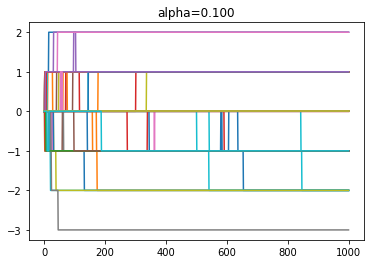

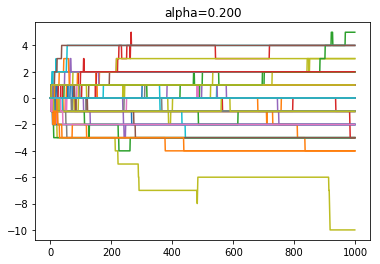

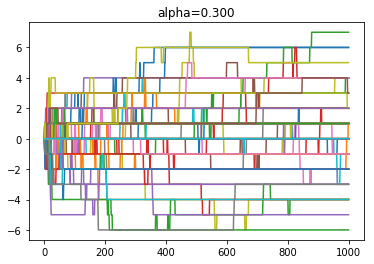

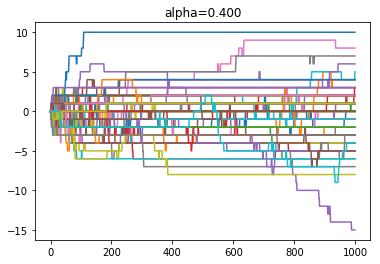

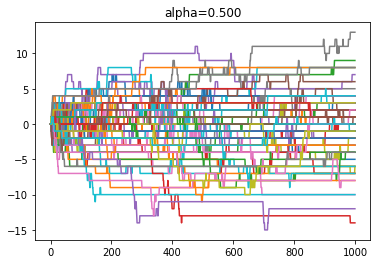

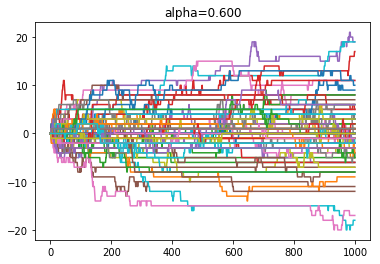

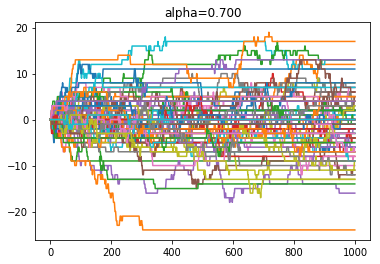

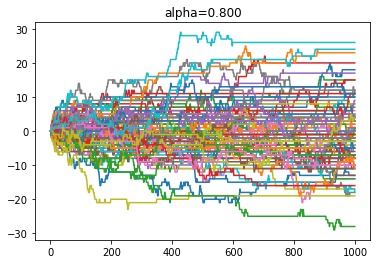

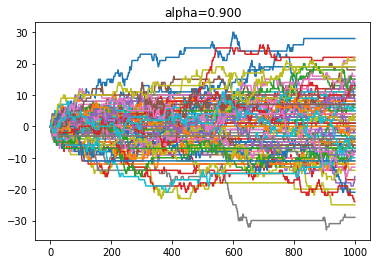

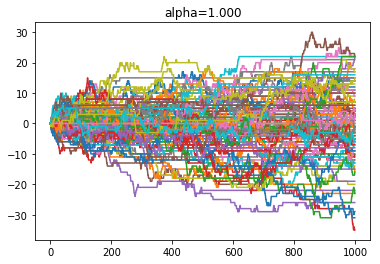

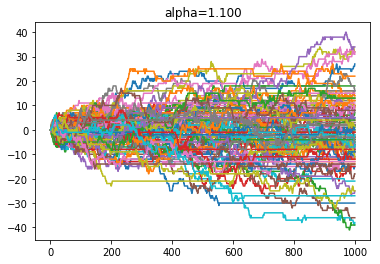

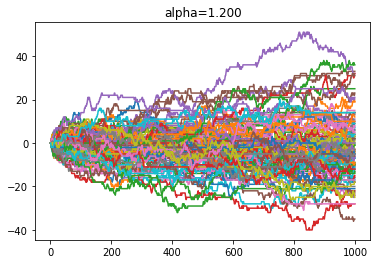

In [16]:
alphas = np.arange(0.1, 1.3, 0.1)
t_max = 1000
num_traj = 100
for alpha in alphas:
    dataset = np.load('ctrw_trajectories/alpha_{:.3}.npy'.format(alpha))
    for i in range(100):
        plt.plot(dataset[i]);
    plt.title('alpha={:.3f}'.format(alpha));
    plt.show();

(5007, 1000)


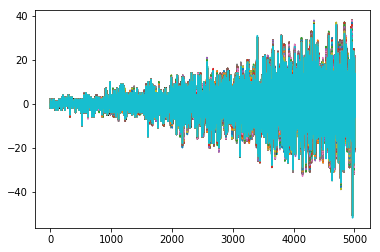

In [23]:
alpha_range = np.arange(0.1, 1.3, 0.1)
num_traj = 5000
ratio_aN = 1./alpha_range.shape[0]
ctrw_loaded = load_ctrw_trajectories(alpha_range, ratio_aN, num_traj=num_traj)
print(ctrw_loaded.shape)
plt.plot(ctrw_loaded);
plt.show()
del ctrw_loaded

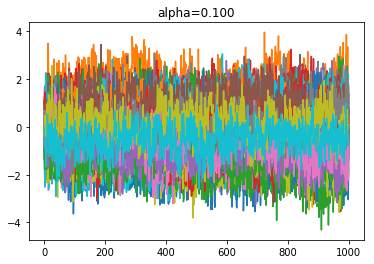

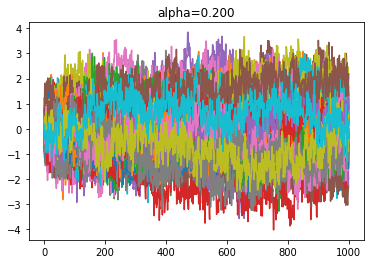

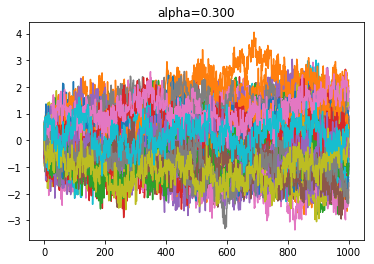

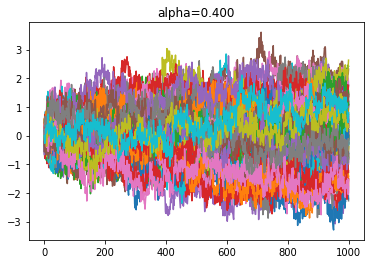

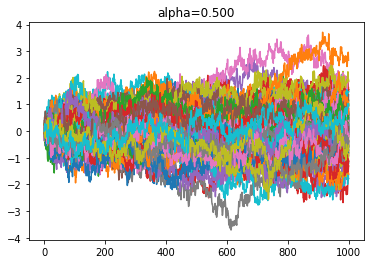

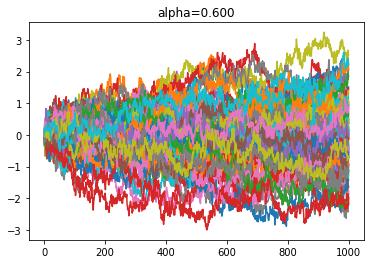

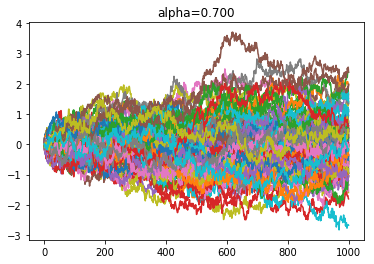

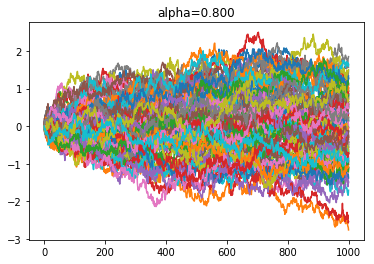

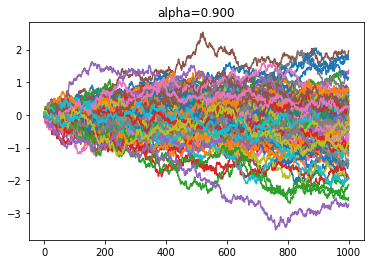

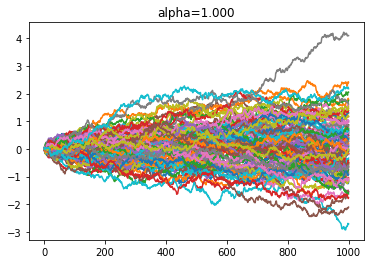

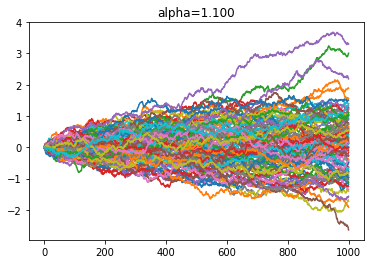

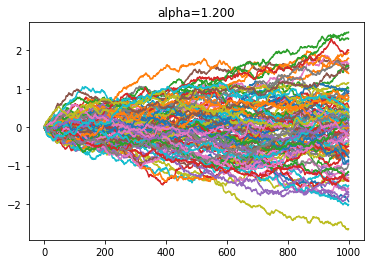

In [24]:
alphas = np.arange(0.1, 1.3, 0.1)
t_max = 1000
num_traj = 100
for alpha in alphas:
    dataset = np.load('fbm_trajectories/alpha_{:.3}.npy'.format(alpha))
    for i in range(100):
        plt.plot(dataset[i]);
    plt.title('alpha={:.3f}'.format(alpha));
    plt.show();

(10008, 1000)


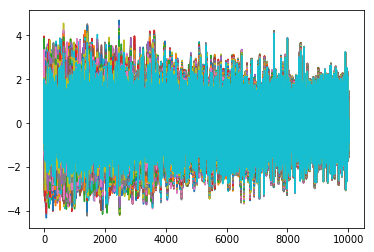

In [26]:
alpha_range = np.arange(0.1, 1.3, 0.1)
num_traj = 10000
ratio_aN = 1./alpha_range.shape[0]
fbm_loaded, _ = load_fbm_trajectories(alpha_range, ratio_aN)
print(fbm_loaded.shape)
plt.plot(fbm_loaded);
plt.show()
del fbm_loaded

In [3]:
def print_heatmap(y_test, y_preds):
    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt="d")
    plt.show()
    
def print_hist(y_probs):
    plt.hist(y_probs)
    plt.title('Probability historgram')
    plt.show()
    
def print_clf_info(y_test, y_preds, y_probs):
    print(classification_report(y_test, y_preds))
    print_heatmap(y_test, y_preds)
    print_hist(y_probs)
    
def get_best_estimator(X_train, y_train, X_test, y_test, parameters, pipeline, scoring=None):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    if scoring is not None:
        clf = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring)
    else:
        clf = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    print_clf_info(y_test, y_preds, y_probs)
    print('Best estimator params_ = {}'.format(clf.best_params_))
    print('Best estimator score_ = {}'.format(clf.best_score_))
    return clf

def get_best_classifier(X_train, y_train, X_test, y_test, names, parameters, pipelines, scoring=None):
    estimators = []
    for name, parameter, pipeline in zip(names, parameters, pipelines):
        print('Finding best estimator for {}...\n'.format(name))
        if scoring is not None:
            clf = get_best_estimator(X_train, y_train, X_test, y_test, parameter, pipeline, scoring=scoring)
        else:
            clf = get_best_estimator(X_train, y_train, X_test, y_test, parameter, pipeline)
        estimators.append([clf.best_estimator_, clf.best_score_, name])
        print('Best estimator for {} is found!\n'.format(name))
    best_estimator = np.array(estimators)[np.array(estimators)[:, 1].argmax()]
    print('Best classifier is found: {}.'.format(best_estimator[2]))
    return best_estimator[0]


In [ ]:
# lr_parameters = {'LogisticRegression__penalty':['l1', 'l2'], 'LogisticRegression__C':[5, 3, 1, 0.5]}
rf_parameters = {'RandomForest__max_depth':[2, 3, 4, None], 
                 'RandomForest__n_estimators':[10, 100, 300, 400, 500],
                 'RandomForest__n_jobs': [-1],
                 'RandomForest__random_state': [42]}
xgb_parameters = {'XGBoost__max_depth':[2, 3, 4, None], 
                  'XGBoost__n_estimators':[10, 100, 300, 400, 500],
                  'XGBoost__n_jobs': [-1], 
                  'XGBoost__random_state': [42]}

# lr_pipeline = Pipeline([('LogisticRegression', LogisticRegression(n_jobs=-1, solver='liblinear', random_state=42))])
rf_pipeline = Pipeline([('RandomForest', RandomForestClassifier())])
xgb_pipeline = Pipeline([('XGBoost', XGBClassifier())])

# names = ['Logistic Regression', 'Random Forest Classifier', 'XGBoost Classifier']
names = ['Random Forest Classifier', 'XGBoost Classifier']
parameters = [rf_parameters, xgb_parameters]
pipelines = [rf_pipeline, xgb_pipeline]

t_max = 1000
num_traj = 10000
processes = np.array(['fbm', 'ctrw'])
alpha_range = np.arange(0.1, 1.3, 0.1)
ratio_tT = 0.8
ratio_aN = 1./alpha_range.shape[0]
T_lag = 2
dataloader = DataLoader(alpha_range, ratio_aN, num_traj, t_max=t_max)

X_train, Y_train, X_test, Y_test = create_training_set(dataloader, 
    num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
best_estimator = get_best_classifier(X_train, Y_train, X_test, Y_test, names, 
                                     parameters, pipelines, scoring='accuracy')

The first experiment of to classify the processes based on the trajectories they produced.

In the experiment below the binary classification task is solved. The labels of trajectories produced by CTRW and FBM models are predicted. Random Forest is used as classificator and the metrics is accuracy as the classes are balanced.

The classification task is solved for different values of $T_{lag}: T_{lag} \in \{0,...,10\}$. To measure the mean scores and their stds for each $T_{lag}$ the 3-fold cross validation is used.

In [16]:
t_max = 1000
num_traj = 12000
processes = np.array(['fbm', 'ctrw'])
alpha_range = np.arange(0.1, 1.3, 0.1)
ratio_tT = 0.8
ratio_aN = 1./alpha_range.shape[0]
T_lags = np.arange(11)
dataloader = DataLoader(alpha_range, ratio_aN, num_traj)

rf_scores = []
rf_scores_means = []
rf_scores_stds = []
for T_lag in T_lags:
    X_train, Y_train, X_test, Y_test = create_training_set(dataloader,
        num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
    rf_res = cross_val_score(rf, X_train, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    rf_scores_means.append(rf_res.mean())
    rf_scores_stds.append(rf_res.std())
    print('RF cv score = {:.3f} +- {:.4f}'.format(rf_scores_means[-1], rf_scores_stds[-1]))
    rf.fit(X_train, Y_train)
    y_test_preds = rf.predict(X_test)
    rf_scores.append(accuracy(y_test_preds, Y_test))
    print('RF test score = {:.3f}'.format(rf_scores[-1]))


Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (24007, 1000), targets_full.shape: (24007, 1)
X_train.shape=(19205, 1000), Y_train.shape = (19205,)
X_test.shape=(4802, 1000), Y_test.shape = (4802,)
RF cv score = 0.999 +- 0.0005
RF test score = 0.999
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (24007, 999), targets_full.shape: (24007, 1)
X_train.shape=(19205, 999), Y_train.shape = (19205,)
X_test.shape=(4802, 999), Y_test.shape = (4802,)
RF cv score = 0.940 +- 0.0028
RF test score = 0.953
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (24007, 500), targets_full.shape: (24007, 1)
X_train.shape=(19205, 500), Y_train.shape = (19205,)
X_test.shape=(4802, 500), Y_test.shape = (4802,)
RF cv score = 0.928 +- 0.0030
RF test score = 0.931
Loading FBM trajectories...
Loading CTRW trajectories...
Creating d

In [ ]:
# rf_scores_means = np.array(rf_scores_means)
# rf_scores_stds = np.array(rf_scores_stds)
# rf_scores = np.array(rf_scores)
# np.save('ctrw_vs_fbm_rf_scores_means.npy', rf_scores_means)
# np.save('ctrw_vs_fbm_rf_scores_stds.npy', rf_scores_stds)
# np.save('ctrw_vs_fbm_rf_scores.npy', rf_scores)

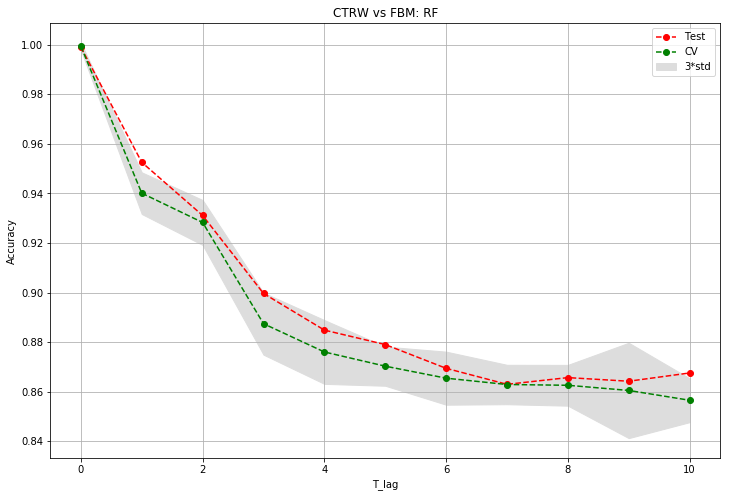

In [38]:
rf_scores_means = np.load('ctrw_vs_fbm_rf_scores_means.npy')
rf_scores_stds = np.load('ctrw_vs_fbm_rf_scores_stds.npy')
rf_scores = np.load('ctrw_vs_fbm_rf_scores.npy')

plt.figure(figsize=(12, 8))
plt.plot(rf_scores, 'o--', color='r', label='Test');
plt.plot(rf_scores_means, 'o--', color='g', label='CV');
plt.gca().fill_between(T_lags, rf_scores_means - 3*rf_scores_stds, rf_scores_means + 3*rf_scores_stds, 
                       color="#dddddd", label="3*std");
plt.grid();
plt.title('CTRW vs FBM: RF');
plt.ylabel('Accuracy');
plt.xlabel('T_lag');
plt.legend();
plt.savefig('CTRW_vs_FBM_RF.png', dpi=200);

In [ ]:
# xgb_scores = []
# xgb_scores_means = []
# xgb_scores_stds = []
# for T_lag in T_lags:
#     X_train, Y_train, X_test, Y_test = create_training_set(dataloader,
#         num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
#     xgb = XGBClassifier(n_jobs=-1, n_estimators=500)
#     xgb_res = cross_val_score(xgb, X_train, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
#     xgb_scores_means.append(xgb_res.mean())
#     xgb_scores_stds.append(xgb_res.std())
#     print('XGBoost cv score = {:.3f} +- {:.4f}'.format(xgb_scores_means[-1], xgb_scores_stds[-1]))
#     xgb.fit(X_train, Y_train)
#     y_test_preds = xgb.predict(X_test)
#     xgb_scores.append(accuracy(y_test_preds, Y_test))
#     print('XGBoost test score = {:.3f}'.format(xgb_scores[-1]))

In [49]:
t_maxes = [10, 20, 30, 40, 50, 60, 70, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
num_traj = 12000
processes = np.array(['fbm', 'ctrw'])
alpha_range = np.arange(0.1, 1.3, 0.1)
ratio_tT = 0.8
ratio_aN = 1./alpha_range.shape[0]
T_lag = 1

rf_scores = []
rf_scores_means = []
rf_scores_stds = []
for t_max in t_maxes:
    dataloader = DataLoader(alpha_range, ratio_aN, num_traj, t_max=t_max)
    X_train, Y_train, X_test, Y_test = create_training_set(dataloader,
        num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
    rf_res = cross_val_score(rf, X_train, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    rf_scores_means.append(rf_res.mean())
    rf_scores_stds.append(rf_res.std())
    print('RF cv score = {:.3f} +- {:.4f}'.format(rf_scores_means[-1], rf_scores_stds[-1]))
    rf.fit(X_train, Y_train)
    y_test_preds = rf.predict(X_test)
    rf_scores.append(accuracy(y_test_preds, Y_test))
    print('RF test score = {:.3f}'.format(rf_scores[-1]))


Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (24007, 9), targets_full.shape: (24007, 1)
X_train.shape=(19205, 9), Y_train.shape = (19205,)
X_test.shape=(4802, 9), Y_test.shape = (4802,)
RF cv score = 0.981 +- 0.0014
RF test score = 0.982
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (24007, 19), targets_full.shape: (24007, 1)
X_train.shape=(19205, 19), Y_train.shape = (19205,)
X_test.shape=(4802, 19), Y_test.shape = (4802,)
RF cv score = 0.984 +- 0.0009
RF test score = 0.984
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (24007, 29), targets_full.shape: (24007, 1)
X_train.shape=(19205, 29), Y_train.shape = (19205,)
X_test.shape=(4802, 29), Y_test.shape = (4802,)
RF cv score = 0.985 +- 0.0012
RF test score = 0.986
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displace

KeyboardInterrupt: 

In [ ]:
rf_scores_means = np.array(rf_scores_means)
rf_scores_stds = np.array(rf_scores_stds)
rf_scores = np.array(rf_scores)
np.save('ctrw_vs_fbm_tmaxes_rf_scores_means.npy', rf_scores_means)
np.save('ctrw_vs_fbm_tmaxes_rf_scores_stds.npy', rf_scores_stds)
np.save('ctrw_vs_fbm_tmaxes_rf_scores.npy', rf_scores)

In [ ]:
rf_scores_means = np.load('ctrw_vs_fbm_tmaxes_rf_scores_means.npy')
rf_scores_stds = np.load('ctrw_vs_fbm_tmaxes_rf_scores_stds.npy')
rf_scores = np.load('ctrw_vs_fbm_rf_tmaxes_scores.npy')

plt.figure(figsize=(12, 8))
plt.plot(rf_scores, 'o--', color='r', label='Test');
plt.plot(rf_scores_means, 'o--', color='g', label='CV');
plt.gca().fill_between(T_lags, rf_scores_means - 3*rf_scores_stds, rf_scores_means + 3*rf_scores_stds, 
                       color="#dddddd", label="3*std");
plt.grid();
plt.title('CTRW vs FBM: RF');
plt.ylabel('Accuracy');
plt.xlabel('t_max');
plt.legend();
plt.savefig('CTRW_vs_FBM_tmaxes_RF.png', dpi=200);

In [28]:
t_max = 1000
num_traj = 16000
processes = np.array(['fbm'])
alpha_range = np.arange(0.3, 1.2, 0.1)
ratio_tT = 0.8
ratio_aN = 1./2
T_lags = np.arange(11)
dataloader = DataLoader(alpha_range, ratio_aN, num_traj, t_max=t_max)
        
rf_scores = []
rf_scores_means = []
rf_scores_stds = []
for T_lag in T_lags:
    X_train, Y_train, X_test, Y_test = create_fbm_anom_set(dataloader,
        num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
    rf_res = cross_val_score(rf, X_train, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    rf_scores_means.append(rf_res.mean())
    rf_scores_stds.append(rf_res.std())
    print('RF cv score = {:.3f} +- {:.4f}'.format(rf_scores_means[-1], rf_scores_stds[-1]))
    rf.fit(X_train, Y_train)
    y_test_preds = rf.predict(X_test)
    rf_scores.append(accuracy(y_test_preds, Y_test))
    print('RF test score = {:.3f}'.format(rf_scores[-1]))

Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (16000, 1000), alphas_fbm.shape: (16000, 1)
X_train.shape=(12800, 1000), Y_train.shape = (12800,)
X_test.shape=(3200, 1000), Y_test.shape = (3200,)
RF cv score = 0.824 +- 0.0056
RF test score = 0.832
Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (16000, 999), alphas_fbm.shape: (16000, 1)
X_train.shape=(12800, 999), Y_train.shape = (12800,)
X_test.shape=(3200, 999), Y_test.shape = (3200,)
RF cv score = 0.811 +- 0.0067
RF test score = 0.812
Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (16000, 500), alphas_fbm.shape: (16000, 1)
X_train.shape=(12800, 500), Y_train.shape = (12800,)
X_test.shape=(3200, 500), Y_test.shape = (3200,)
RF cv score = 0.781 +- 0.0028
RF test score = 0.787
Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (16000, 334), alphas_fbm.shape: (16000, 1)
X_train.shape=(12800, 334), Y_train

In [29]:
# rf_scores_means = np.array(rf_scores_means)
# rf_scores_stds = np.array(rf_scores_stds)
# rf_scores = np.array(rf_scores)
# np.save('anom_rf_scores_means.npy', rf_scores_means)
# np.save('anom_fbm_rf_scores_stds.npy', rf_scores_stds)
# np.save('anom_rf_scores.npy', rf_scores)

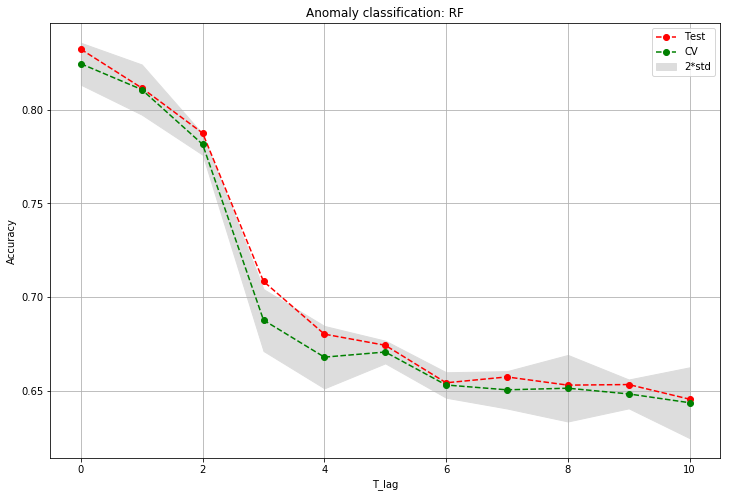

In [36]:
rf_scores_means = np.load('anom_rf_scores_means.npy')
rf_scores_stds = np.load('anom_fbm_rf_scores_stds.npy')
rf_scores = np.load('anom_rf_scores.npy')

plt.figure(figsize=(12, 8))
plt.plot(rf_scores, 'o--', color='r', label='Test');
plt.plot(rf_scores_means, 'o--', color='g', label='CV');
plt.gca().fill_between(T_lags, rf_scores_means - 2*rf_scores_stds, rf_scores_means + 2*rf_scores_stds, 
                       color="#dddddd", label="2*std");
plt.grid();
plt.title('Anomaly classification: RF');
plt.ylabel('Accuracy');
plt.xlabel('T_lag');
plt.legend();
plt.savefig('Anomaly_RF.png', dpi=200);

In [41]:
t_max = 1000
num_traj = 16000
processes = np.array(['fbm'])
alpha_range = np.arange(0.3, 1.2, 0.1)
ratio_tT = 0.8
ratio_aN = 1./2
T_lag = 1
dataloader = DataLoader(alpha_range, ratio_aN, num_traj, t_max=t_max)
X_train, Y_train, X_test, Y_test = create_fbm_anom_set(dataloader,
        num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
rf.fit(X_train, Y_train)

sigmas = [0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7]
rf_scores_noised = []
for sigma in sigmas:
    noise = np.random.randn(X_test.shape[0], X_test.shape[1]) * sigma
    X_test_noised = X_test.copy() + noise
    y_test_preds = rf.predict(X_test_noised)
    rf_scores_noised.append(accuracy(y_test_preds, Y_test))
    print('RF test score = {:.3f} with noise = {}'.format(rf_scores_noised[-1], sigma))

Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (16000, 999), alphas_fbm.shape: (16000, 1)
X_train.shape=(12800, 999), Y_train.shape = (12800,)
X_test.shape=(3200, 999), Y_test.shape = (3200,)
RF test score = 0.811 with noise = 0.1
RF test score = 0.811 with noise = 0.1
RF test score = 0.811 with noise = 0.2
RF test score = 0.811 with noise = 0.3
RF test score = 0.808 with noise = 0.4
RF test score = 0.813 with noise = 0.5
RF test score = 0.810 with noise = 0.6
RF test score = 0.814 with noise = 0.7
RF test score = 0.811 with noise = 0.8
RF test score = 0.810 with noise = 0.9
RF test score = 0.810 with noise = 1
RF test score = 0.808 with noise = 1.5
RF test score = 0.810 with noise = 2
RF test score = 0.804 with noise = 2.5
RF test score = 0.794 with noise = 3
RF test score = 0.763 with noise = 4
RF test score = 0.652 with noise = 5
RF test score = 0.510 with noise = 6
RF test score = 0.485 with noise = 7


In [46]:
# rf_scores_noised = np.array(rf_scores_noised)
# sigmas = np.array(sigmas)
# np.save('noise_rf_scores_noised.npy', rf_scores_noised)
# np.save('noise_sigmas.npy', sigmas)

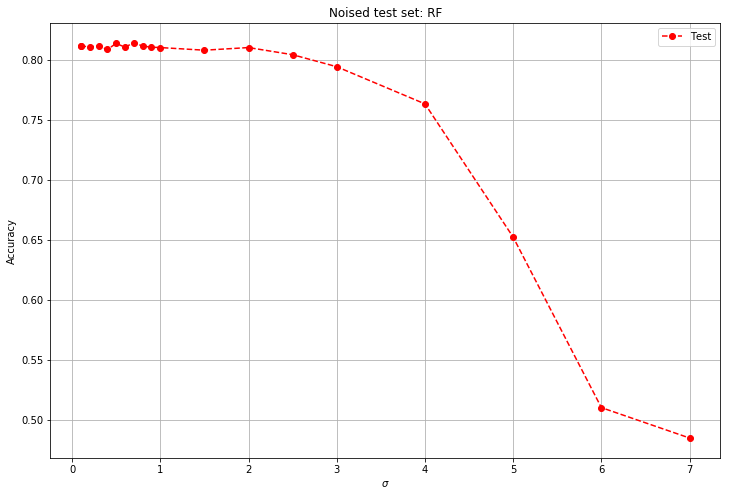

In [47]:
rf_scores_noised = np.load('noise_rf_scores_noised.npy')
sigmas = np.load('noise_sigmas.npy')

plt.figure(figsize=(12, 8))
plt.plot(sigmas, rf_scores_noised, 'o--', color='r', label='Test');
plt.grid();
plt.title('Noised test set: RF');
plt.ylabel('Accuracy');
plt.xlabel('$\sigma$');
plt.legend();
plt.savefig('Noised_testset_RF.png', dpi=200);

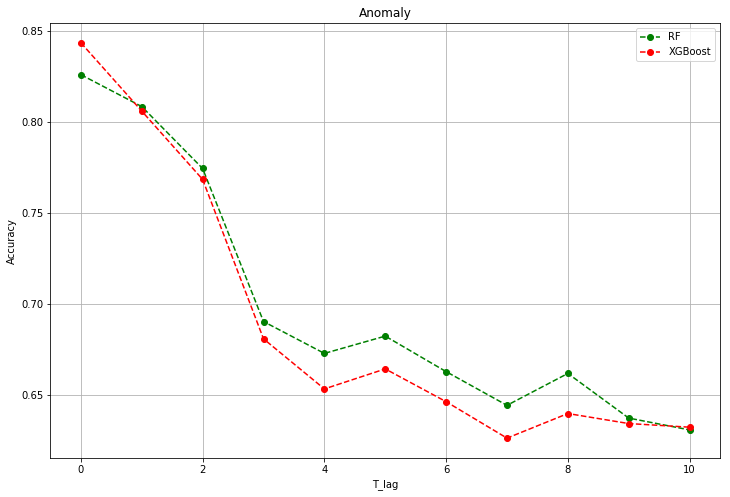

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(rf_scores, 'o--', color='g', label='RF');
plt.plot(xgb_scores, 'o--', color='r', label='XGBoost');
plt.grid()
plt.title('Anomaly')
plt.ylabel('Accuracy')
plt.xlabel('T_lag')
plt.legend();

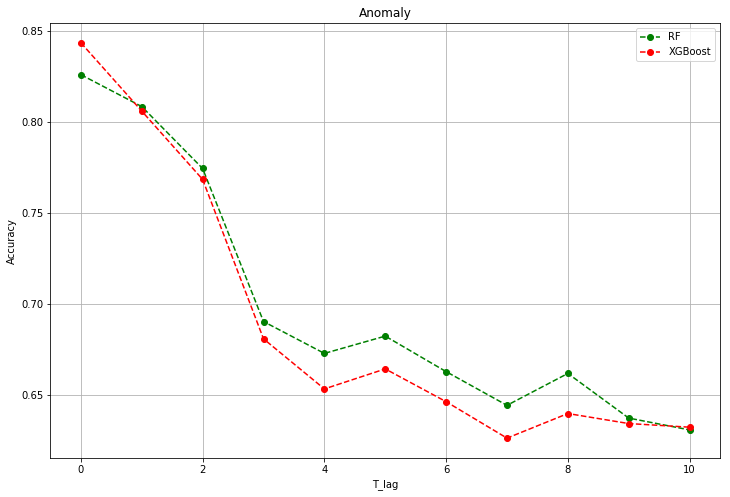

In [6]:
# np.save('rf_scores_anom.npy', np.array(rf_scores))
# np.save('xgb_scores_anom.npy', np.array(xgb_scores))

rf_scores = np.load('rf_scores_anom.npy')
xgb_scores = np.load('xgb_scores_anom.npy')

plt.figure(figsize=(12, 8))
plt.plot(rf_scores, 'o--', color='g', label='RF');
plt.plot(xgb_scores, 'o--', color='r', label='XGBoost');
plt.grid()
plt.title('Anomaly')
plt.ylabel('Accuracy')
plt.xlabel('T_lag')
plt.legend();
plt.savefig('anom1.png')

In [50]:
t_maxes = [10, 15, 20, 30, 40, 50, 60, 70, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
num_traj = 10000
processes = np.array(['fbm'])
alpha_range = np.arange(0.3, 1.2, 0.1)
ratio_tT = 0.8
ratio_aN = 1./2
T_lag = 0

rf_scores = []
xgb_scores = []
for t_max in t_maxes:
    dataloader = DataLoader(alpha_range, ratio_aN, num_traj, t_max=t_max)
    X_train, Y_train, X_test, Y_test = create_fbm_anom_set(dataloader, 
        num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
    rf.fit(X_train, Y_train)
    y_test_preds = rf.predict(X_test)
    rf_scores.append(accuracy(y_test_preds, Y_test))
    print('RF score = {}'.format(rf_scores[-1]))
    xgb = XGBClassifier(n_jobs=-1, n_estimators=500)
    xgb.fit(X_train, Y_train)
    y_test_preds = xgb.predict(X_test)
    xgb_scores.append(accuracy(y_test_preds, Y_test))
    print('XGB score = {}'.format(xgb_scores[-1]))

Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (10000, 10), alphas_fbm.shape: (10000, 1)
X_train.shape=(8000, 10), Y_train.shape = (8000,)
X_test.shape=(2000, 10), Y_test.shape = (2000,)
RF score = 0.84
XGB score = 0.8375
Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (10000, 15), alphas_fbm.shape: (10000, 1)
X_train.shape=(8000, 15), Y_train.shape = (8000,)
X_test.shape=(2000, 15), Y_test.shape = (2000,)
RF score = 0.8395
XGB score = 0.8475
Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (10000, 20), alphas_fbm.shape: (10000, 1)
X_train.shape=(8000, 20), Y_train.shape = (8000,)
X_test.shape=(2000, 20), Y_test.shape = (2000,)
RF score = 0.841
XGB score = 0.8465
Loading FBM trajectories...
Creating dataset displacements...
disp_dataset.shape: (10000, 30), alphas_fbm.shape: (10000, 1)
X_train.shape=(8000, 30), Y_train.shape = (8000,)
X_test.shape=(2000, 30), Y_test.shape = (2000,)
RF s

KeyboardInterrupt: 

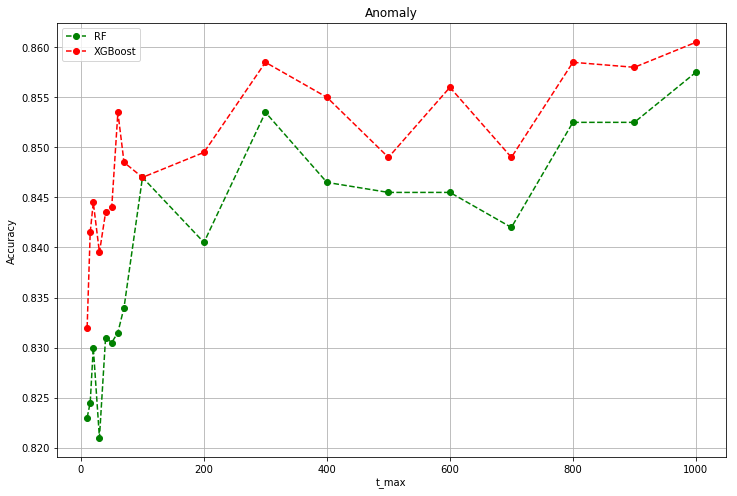

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(t_maxes, rf_scores[::-1], 'o--', color='g', label='RF');
plt.plot(t_maxes, xgb_scores[::-1], 'o--', color='r', label='XGBoost');
plt.grid()
plt.title('Anomaly')
plt.ylabel('Accuracy')
plt.xlabel('t_max')
plt.legend();

In [59]:
# np.save('rf_scores_anom_tmaxes.npy', np.array(rf_scores))
# np.save('xgb_scores_anom_tmaxes.npy', np.array(xgb_scores))

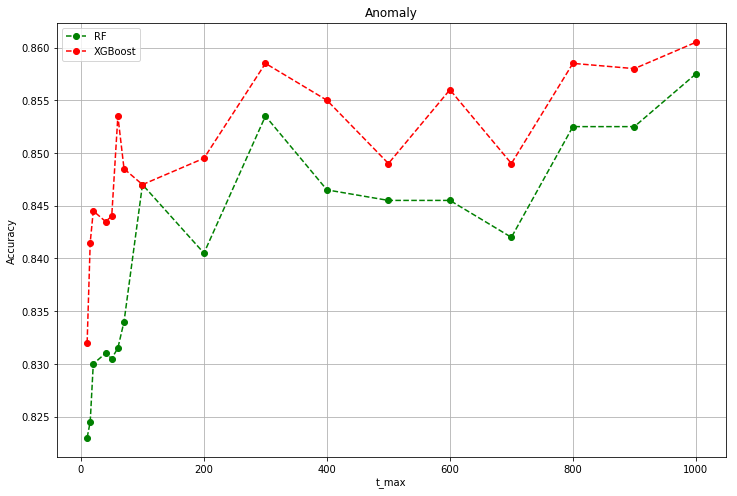

In [59]:
# np.save('rf_scores_anom.npy', np.array(rf_scores))
# np.save('xgb_scores_anom.npy', np.array(xgb_scores))
t_maxes = [10, 15, 20, 40, 50, 60, 70, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# rf_scores = np.load('rf_scores_anom_tmaxes.npy')
# xgb_scores = np.load('xgb_scores_anom_tmaxes.npy')

plt.figure(figsize=(12, 8))
plt.plot(t_maxes, rf_scores, 'o--', color='g', label='RF');
plt.plot(t_maxes, xgb_scores, 'o--', color='r', label='XGBoost');
plt.grid()
plt.title('Anomaly')
plt.ylabel('Accuracy')
plt.xlabel('t_max')
plt.legend();
plt.savefig('anom2.png')

In [56]:
l = list(rf_scores[::-1])
del l[3]
rf_scores = l

l = list(xgb_scores[::-1])
del l[3]
xgb_scores = l

In [ ]:
y_preds = best_estimator.predict(X_test)
print('Accuracy = {:.3f}'.format(accuracy(y_preds, Y_test)))

In [252]:
t_max = 1000
num_traj = 10000
processes = np.array(['fbm', 'ctrw'])
alpha_range = np.arange(0.1, 1.3, 0.1)
ratio_tT = 0.8
ratio_aN = 1./alpha_range.shape[0]
T_lags = np.arange(11)
dataloader = DataLoader(alpha_range, ratio_aN, num_traj)

rf_scores = []
xgb_scores = []
for T_lag in T_lags:
    X_train, Y_train, X_test, Y_test = create_training_set(dataloader,
        num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
    rf.fit(X_train, Y_train)
    y_test_preds = rf.predict(X_test)
    rf_scores.append(accuracy(y_test_preds, Y_test))
    print('RF score = {}'.format(rf_scores[-1]))
    xgb = XGBClassifier(n_jobs=-1, n_estimators=500)
    xgb.fit(X_train, Y_train)
    y_test_preds = xgb.predict(X_test)
    xgb_scores.append(accuracy(y_test_preds, Y_test))
    print('XGB score = {}'.format(xgb_scores[-1]))

Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (20013, 1000), targets_full.shape: (20013, 1)
X_train.shape=(16010, 1000), Y_train.shape = (16010,)
X_test.shape=(4003, 1000), Y_test.shape = (4003,)
RF score = 0.9995003747189608
XGB score = 1.0
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 999), targets_full.shape: (20013, 1)
X_train.shape=(15198, 999), Y_train.shape = (15198,)
X_test.shape=(3805, 999), Y_test.shape = (3805,)
RF score = 0.9340341655716163
XGB score = 0.9931668856767412
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 500), targets_full.shape: (20013, 1)
X_train.shape=(15078, 500), Y_train.shape = (15078,)
X_test.shape=(3774, 500), Y_test.shape = (3774,)
RF score = 0.9205087440381559
XGB score = 0.9745627980922098
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 334), targets_full.shape: (20013, 1)
X_train.shape=(15101, 334), Y_train.shape = (15101,)
X_test.shape=(3816, 334), Y_test.shape = (3816,)
RF score = 0.8818134171907757
XGB score = 0.925314465408805
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 250), targets_full.shape: (20013, 1)
X_train.shape=(15165, 250), Y_train.shape = (15165,)
X_test.shape=(3748, 250), Y_test.shape = (3748,)
RF score = 0.8762006403415155
XGB score = 0.8988794023479189
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 200), targets_full.shape: (20013, 1)
X_train.shape=(15127, 200), Y_train.shape = (15127,)
X_test.shape=(3775, 200), Y_test.shape = (3775,)
RF score = 0.8717880794701987
XGB score = 0.8887417218543047
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 167), targets_full.shape: (20013, 1)
X_train.shape=(15105, 167), Y_train.shape = (15105,)
X_test.shape=(3793, 167), Y_test.shape = (3793,)
RF score = 0.856841550224097
XGB score = 0.8760875296598998
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 143), targets_full.shape: (20013, 1)
X_train.shape=(15115, 143), Y_train.shape = (15115,)
X_test.shape=(3770, 143), Y_test.shape = (3770,)
RF score = 0.8525198938992042
XGB score = 0.8732095490716181
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 125), targets_full.shape: (20013, 1)
X_train.shape=(15084, 125), Y_train.shape = (15084,)
X_test.shape=(3773, 125), Y_test.shape = (3773,)
RF score = 0.8698648290485025
XGB score = 0.8685396236416645
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 112), targets_full.shape: (20013, 1)
X_train.shape=(15085, 112), Y_train.shape = (15085,)
X_test.shape=(3780, 112), Y_test.shape = (3780,)
RF score = 0.8513227513227514
XGB score = 0.8682539682539683
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...


/Users/kolya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


disp_dataset.shape: (20013, 100), targets_full.shape: (20013, 1)
X_train.shape=(15088, 100), Y_train.shape = (15088,)
X_test.shape=(3770, 100), Y_test.shape = (3770,)
RF score = 0.8570291777188329
XGB score = 0.8620689655172413


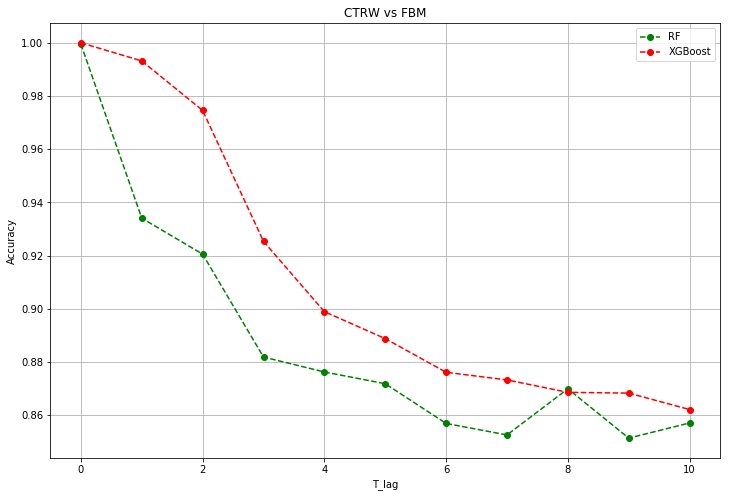

In [266]:
plt.figure(figsize=(12, 8))
plt.plot(rf_scores, 'o--', color='g', label='RF');
plt.plot(xgb_scores, 'o--', color='r', label='XGBoost');
plt.grid()
plt.title('CTRW vs FBM')
plt.ylabel('Accuracy')
plt.xlabel('T_lag')
plt.legend();

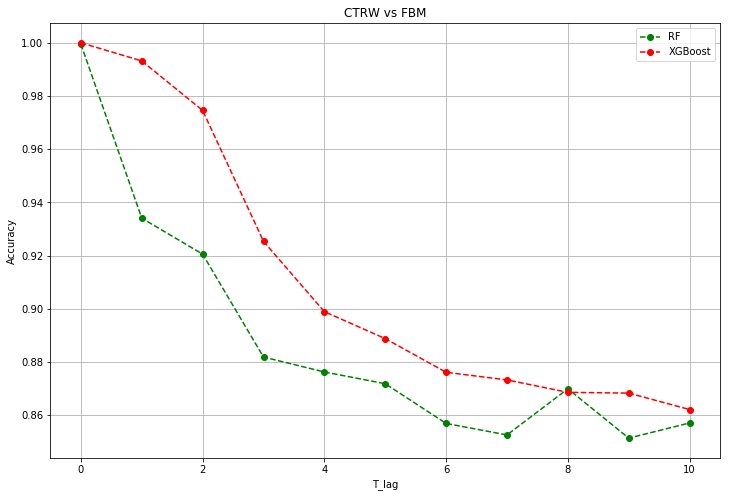

In [5]:
# np.save('rf_scores.npy', np.array(rf_scores))
# np.save('xgb_scores.npy', np.array(xgb_scores))

rf_scores = np.load('rf_scores.npy')
xgb_scores = np.load('xgb_scores.npy')
plt.figure(figsize=(12, 8))
plt.plot(rf_scores, 'o--', color='g', label='RF');
plt.plot(xgb_scores, 'o--', color='r', label='XGBoost');
plt.grid()
plt.title('CTRW vs FBM')
plt.ylabel('Accuracy')
plt.xlabel('T_lag')
plt.legend();
plt.savefig('p1.png')

In [23]:
t_maxes = [10, 15, 20, 30, 40, 50, 60, 70, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
num_traj = 10000
processes = np.array(['fbm', 'ctrw'])
alpha_range = np.arange(0.1, 1.3, 0.1)
ratio_tT = 0.8
ratio_aN = 1./alpha_range.shape[0]
T_lag = 1

rf_scores = []
xgb_scores = []
for t_max in t_maxes:
    dataloader = DataLoader(alpha_range, ratio_aN, num_traj, t_max)
    X_train, Y_train, X_test, Y_test = create_training_set(dataloader,
        num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
    rf.fit(X_train, Y_train)
    y_test_preds = rf.predict(X_test)
    rf_scores.append(accuracy(y_test_preds, Y_test))
    print('RF score = {}'.format(rf_scores[-1]))
    xgb = XGBClassifier(n_jobs=-1, n_estimators=500)
    xgb.fit(X_train, Y_train)
    y_test_preds = xgb.predict(X_test)
    xgb_scores.append(accuracy(y_test_preds, Y_test))
    print('XGB score = {}'.format(xgb_scores[-1]))

Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (20013, 9), targets_full.shape: (20013, 1)
X_train.shape=(13071, 9), Y_train.shape = (13071,)
X_test.shape=(3263, 9), Y_test.shape = (3263,)
RF score = 0.980386147716825
XGB score = 0.9665951578302175
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (20013, 14), targets_full.shape: (20013, 1)
X_train.shape=(13493, 14), Y_train.shape = (13493,)
X_test.shape=(3376, 14), Y_test.shape = (3376,)
RF score = 0.9825236966824644
XGB score = 0.9786729857819905
Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (20013, 19), targets_full.shape: (20013, 1)
X_train.shape=(13726, 19), Y_train.shape = (13726,)
X_test.shape=(3448, 19), Y_test.shape = (3448,)
RF score = 0.9854988399071926
XGB score = 0.9788283062645011
Loading FBM trajectories...
Loading CTRW trajectories...

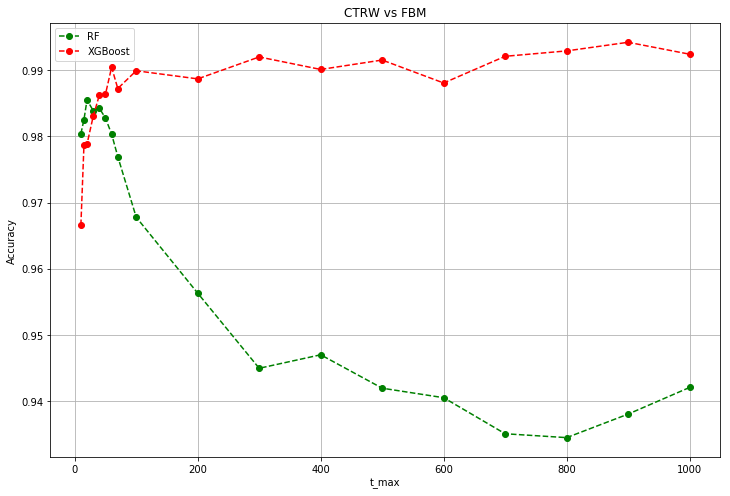

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(t_maxes, rf_scores, 'o--', color='g', label='RF');
plt.plot(t_maxes, xgb_scores, 'o--', color='r', label='XGBoost');
plt.grid()
plt.title('CTRW vs FBM')
plt.ylabel('Accuracy')
plt.xlabel('t_max')
plt.legend();

In [25]:
np.save('rf_scores_tmaxes.npy', np.array(rf_scores))
np.save('xgb_scores_tmaxes.npy', np.array(xgb_scores))

In [204]:
# for x in X_train:
#     for elem in x:
#         if np.isnan(elem):
#             print()

X_train_new = X_train[~np.isnan(X_train)]
print(X_train_new.reshape(-1, 500).shape)
Y_train_new = Y_train[~np.isnan(X_train[:, -1])]
print(Y_train_new.shape)

(7530, 500)
(7530,)


In [116]:
arr = np.arange(16).reshape((4, 4))+1
# print(arr)
vec = np.array([0, 0, 1, 0]).reshape((4, 1))
arr = np.hstack((arr, vec))
print(arr)
print(arr[:3, :-1])
print(arr[:3, -1])

print(arr[3:, :-1])
print(arr[3:, -1])
np.random.shuffle(arr)
arr

[[ 1  2  3  4  0]
 [ 5  6  7  8  0]
 [ 9 10 11 12  1]
 [13 14 15 16  0]]
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
[0 0 1]
[[13 14 15 16]]
[0]


array([[13, 14, 15, 16,  0],
       [ 5,  6,  7,  8,  0],
       [ 9, 10, 11, 12,  1],
       [ 1,  2,  3,  4,  0]])

In [7]:
t_max = 1000
num_traj = 10000
processes = np.array(['fbm', 'ctrw'])
alpha_range = np.arange(0.1, 1.3, 0.1)
ratio_tT = 0.8
ratio_aN = 1./alpha_range.shape[0]
T_lag = 3
dataloader = DataLoader(alpha_range, ratio_aN, num_traj)


X_train, Y_train, X_test, Y_test = create_training_set(dataloader,
    num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
rf.fit(X_train, Y_train)
y_test_preds = rf.predict(X_test)
print('RF score = {}'.format(accuracy(y_test_preds, Y_test))
xgb = XGBClassifier(n_jobs=-1, n_estimators=500)
xgb.fit(X_train, Y_train)
y_test_preds = xgb.predict(X_test)
print('XGB score = {}'.format(accuracy(y_test_preds, Y_test)))

Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (20013, 334), targets_full.shape: (20013, 1)
X_train.shape=(16010, 334), Y_train.shape = (16010,)
X_test.shape=(4003, 334), Y_test.shape = (4003,)
RF score = 0.8860854359230577
XGB score = 0.9303022732950287


In [13]:
t_max = 1000
num_traj = 16000
processes = np.array(['fbm', 'ctrw'])
alpha_range = np.arange(0.1, 1.3, 0.1)
ratio_tT = 0.8
ratio_aN = 1./alpha_range.shape[0]
T_lag = 3
dataloader = DataLoader(alpha_range, ratio_aN, num_traj)


X_train, Y_train, X_test, Y_test = create_training_set(dataloader,
    num_traj, alpha_range, ratio_aN, processes, T_lag, ratio_tT)
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
# rf.fit(X_train, Y_train)
# y_test_preds = rf.predict(X_test)
print('RF score = {}'.format(cross_val_score(rf, X_train, Y_train, cv=3, scoring='accuracy')))
xgb = XGBClassifier(n_jobs=-1, n_estimators=500)
# xgb.fit(X_train, Y_train)
# y_test_preds = xgb.predict(X_test)
print('XGB score = {}'.format(cross_val_score(xgb, X_train, Y_train, cv=3, scoring='accuracy')))

Loading FBM trajectories...
Loading CTRW trajectories...
Creating dataset displacements...
disp_dataset.shape: (32012, 334), targets_full.shape: (32012, 1)
X_train.shape=(25609, 334), Y_train.shape = (25609,)
X_test.shape=(6403, 334), Y_test.shape = (6403,)
RF score = [0.88836828 0.89175258 0.89151828]


KeyboardInterrupt: 

In [12]:
y_test_preds = rf.predict(X_test)
print('RF score = {}'.format(accuracy(y_test_preds, Y_test)))
y_test_preds = xgb.predict(X_test)
print('XGB score = {}'.format(accuracy(y_test_preds, Y_test)))

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.